In [72]:
from langgraph.graph import StateGraph, END, START
from langchain_google_genai import ChatGoogleGenerativeAI
from pydantic import BaseModel, Field
from typing import TypedDict, Literal, Annotated
from langchain_core.messages import SystemMessage, HumanMessage
import os
from dotenv import load_dotenv

In [73]:
load_dotenv()

True

In [74]:
generator_llm = ChatGoogleGenerativeAI(
    model = 'gemini-2.5-flash',
    google_api_key = os.getenv('GEMINI_API_KEY')
)

E0000 00:00:1759657625.588559 3833133 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


In [75]:
evaluator_llm = ChatGoogleGenerativeAI(
    model = 'gemini-2.5-flash',
    google_api_key = os.getenv('GEMINI_API_KEY')
)

E0000 00:00:1759657625.594103 3833133 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


In [76]:
optimizer_llm = ChatGoogleGenerativeAI(
    model = 'gemini-2.5-flash',
    google_api_key = os.getenv('GEMINI_API_KEY')
)

E0000 00:00:1759657625.599042 3833133 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


In [77]:
class TweetState(TypedDict):

    topic : str
    tweet : str
    evaluation : Literal["approved", "needs_improvement"]
    feedback : str
    iteration : str
    max_iteration : int

In [78]:
from pydantic import BaseModel, Field

class TweetEvaluation(BaseModel):
    evaluation: Literal["approved", "needs_improvement"] = Field(..., description="Final evaluation result.")
    feedback: str = Field(..., description="feedback for the tweet.")

In [79]:
structured_evaluator_llm = evaluator_llm.with_structured_output(TweetEvaluation)

In [80]:
def generate_tweet( state: TweetState):

    #prompt
    messages = [
    SystemMessage(content="You are a funny and clever Twitter/X influencer."),
    HumanMessage(content=f"""
    Write a short, original, and hilarious tweet on the topic: "{state['topic']}".

    Rules:
    - Do NOT use question-answer format.
    - Max 280 characters.
    - Use observational humor, irony, sarcasm, or cultural references.
    - Think in meme logic, punchlines, or relatable takes.
    - Use simple, day to day english
    - This is version {state['iteration'] + 1}.
    """)
    ]

    #generator llm
    response = generator_llm.invoke(messages).content

    return {'tweet' : response}

In [81]:
def evaluate_tweet ( state : TweetState):

    messages = [
    SystemMessage(content="You are a ruthless, no-laugh-given Twitter Critic. You evaluate tweets based on humor, originality, virality, and tweet format."),
    HumanMessage(content=f"""
    Evaluate the following tweet:

    Tweet: "{state['tweet']}"

    Use the criteria below to evaluate the tweet:

    1. Originality - Is this fresh, or have you seen it a hundred times before?
    2. Humor - Did it genuinely make you smile, laugh, or chuckle?
    3. Punchiness - Is it short, sharp, and scroll-stopping?
    4. Virality Potential - Would people retweet or share it?
    5. Format - Is it a well-formed tweet (not a setup-punchline joke, not a Q&A joke, and under 280 characters)?

    Auto-reject if:
    - It's written in question-answer format (e.g., "Why did..." or "What happens when...")
    - It exceeds 280 characters
    - It reads like a traditional setup-punchline joke
    - Dont end with generic, throwaway, or deflating lines that weaken the humor (e.g., "Masterpieces of the auntie-uncle universe" or vague summaries)

    ### Respond ONLY in structured format:
    evaluation: "approved" or "needs_improvement"
    feedback: One paragraph explaining the strengths and weaknesses
    """)
    ]

    response = structured_evaluator_llm.invoke(messages)

    return { 'evaluation' : response.evaluation, 'feedback' : response.feedback}

In [82]:
def optimize_tweet ( state : TweetState):

    messages = [
    SystemMessage(content="You punch up tweets for virality and humor based on given feedback."),
    HumanMessage(content=f"""
    Improve the tweet based on this feedback:
    "{state['feedback']}"

    Topic: "{state['topic']}"
    Original Tweet:
    {state['tweet']}

    Re-write it as a short, viral-worthy tweet. Avoid Q&A style and stay under 280 characters.
    """)
    ]

    response = optimizer_llm.invoke(messages).content
    iteration = state['iteration'] + 1

    return { 'tweet' : response , 'iteration' : iteration}


In [83]:
def route_evaluation ( state : TweetState):

    if state['evaluation'] == 'approved' or state['iteration'] >= state['max_iteration']:
        return 'approved'
    else:
        return 'needs_improvement'

In [84]:
graph = StateGraph(TweetState)

graph.add_node('generate', generate_tweet )
graph.add_node('evaluate', evaluate_tweet )
graph.add_node('optimize', optimize_tweet )

graph.add_edge( START, 'generate')
graph.add_edge( 'generate', 'evaluate' )

# On the basis of the evaluate the iteration is needed to be performed.
graph.add_conditional_edges( 'evaluate', route_evaluation, {'approved' : END, 'needs_improvement' : 'optimize'})
#Here the connection has been created and now the returning link is to be created between the optimize and the generate

graph.add_edge( 'optimize', 'generate')

workflow = graph.compile()


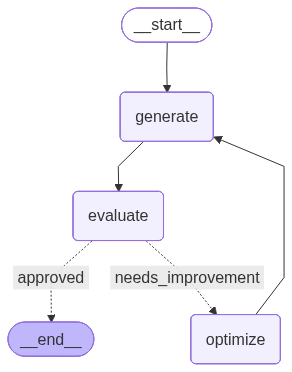

In [85]:
workflow

In [86]:
initial_state = {

    'topic' : 'Indian Army',
    'iteration' : 0,
    'max_iteration': 5
}

workflow.invoke(initial_state)

{'topic': 'Indian Army',
 'tweet': 'My phone battery dropping below 50% gives me anxiety. Meanwhile, the Indian Army probably runs on pure willpower and the belief that chai will appear anywhere, anytime. Legend.',
 'evaluation': 'approved',
 'feedback': 'The tweet effectively uses relatable anxiety about phone battery life to create a humorous contrast with the perceived resilience of the Indian Army, powered by willpower and the ubiquitous availability of chai. The specific detail about chai appearing "anywhere, anytime" adds a strong comedic element and cultural resonance, enhancing both its humor and potential for virality. The format is appropriate for Twitter, avoiding common pitfalls like Q&A or setup-punchline structures, and it stays well within the character limit, making it a well-crafted and engaging post.',
 'iteration': 0,
 'max_iteration': 5}